## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV # для оптимизации гиперпараметров
from sklearn.pipeline import Pipeline #
from sklearn import tree
from sklearn import decomposition, datasets
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [24]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

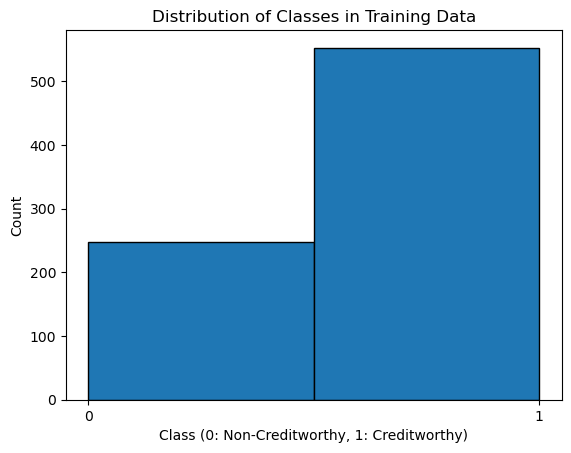

In [25]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

In [28]:
# Создание модели логической регрессии и определение грид-парамов
logistic_regression_model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

logistic_regression_model_random = GridSearchCV(estimator=logistic_regression_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)


# Создание объекта логической регрессионной модели
logistic_regression_model = logistic_regression_model_random.fit(X_train, y_train)#Обучение

# Создание решающего дерева
decision_tree_model = DecisionTreeClassifier()


parameters = {
'criterion': ['gini', 'entropy'],
'max_depth': [None, 5, 10, 15],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
}

# Поиск по сетке, используя кросс-валидацию
grid_search = GridSearchCV(decision_tree_model, parameters, cv=5)
decision_tree_model = grid_search.fit(X, y)


# Создание модели KNN
knn_model = KNeighborsClassifier()
pipeline = Pipeline([
('scaler', StandardScaler()),
('knn', knn_model)
])

# параметры для грида
parameters = {
'knn__n_neighbors': [3, 5, 7, 9],
'knn__weights': ['uniform', 'distance'],
'knn__p': [1, 2]
}

# Поиск по сетке, используя кросс-валидацию
grid_search = GridSearchCV(pipeline, parameters, cv=5)
knn_model = grid_search.fit(X, y)

In [29]:
y_prob_logistic = logistic_regression_model.predict_proba(X_test)[:, 1]
y_prob_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

y_pred_logistic = logistic_regression_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

precision_logistic = precision_score(y_test, y_pred_logistic)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
precision_knn = precision_score(y_test, y_pred_knn)

recall_logistic = recall_score(y_test, y_pred_logistic)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy of Logistic Regression: {accuracy_logistic}')
print(f'Accuracy of Decision Tree: {accuracy_decision_tree}')
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn}')

print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}')

print(f'Precision of Logistic Regression: {precision_logistic}')
print(f'Precision of Decision Tree: {precision_decision_tree}')
print(f'Precision of K-Nearest Neighbors: {precision_knn}')

print(f'Recall of Logistic Regression: {recall_logistic}')
print(f'Recall of Decision Tree: {recall_decision_tree}')
print(f'Recall of K-Nearest Neighbors: {recall_knn}')

Accuracy of Logistic Regression: 0.79
Accuracy of Decision Tree: 0.815
Accuracy of K-Nearest Neighbors: 0.81
ROC AUC of Logistic Regression: 0.7983570786805287
ROC AUC of Decision Tree: 0.8732511872673597
ROC AUC of K-Nearest Neighbors: 0.8464895392119112
Precision of Logistic Regression: 0.8387096774193549
Precision of Decision Tree: 0.8666666666666667
Precision of K-Nearest Neighbors: 0.8263473053892215
Recall of Logistic Regression: 0.8843537414965986
Recall of Decision Tree: 0.8843537414965986
Recall of K-Nearest Neighbors: 0.9387755102040817


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели